In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error as mape 
from sklearn.metrics import mean_squared_error as mse
import joblib
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#Test de estacionariedad
def DFtest(serie):
    ''' Una serie es estacionaria si su residuo:
    - Tiene media constante a lo largo del tiempo
    - Tiene varianza constante a lo largo del tiempo (homocedasticidad) 
    - Tiene una autocorrelación constante a lo largo del tiempo
    '''
    print("Resultados del Test de Dickey-Fuller (H0= NO estac.):")
    dftest=adfuller(serie, autolag = "AIC")
    hipotesis_test=['Serie no estacionaria' if dftest[1]>0.025 else 'Serie estacionaria']
    dfoutput=pd.Series([round(dftest[0],4), round(dftest[1]*100, 4), hipotesis_test[0]], index = ["Estadístico", "P-valor(%)", "Hipótesis (α=2,5%)"])
    return dfoutput

#Media ponderada de estacionalidad
def media_ponderada(estacionalidad):
    """
    Calcula la media ponderada del componente estacional dando más peso
    a las observaciones más recientes.
    """
    #Pasamos a frame 
    estacionalidad=estacionalidad.to_frame(name='valor')
    #Pasamos de fecha a dia de la semana
    estacionalidad.index=estacionalidad.index.day_name()
    #Creamos un diccionario con el orden dinámico del ciclo de dias
    df_dias=dict.fromkeys(estacionalidad.index[-7:].to_list(), None)
    #Creamos una lista para agregar la media ponderada de cada superiodo del ciclo
    ciclo_esta=[]
    
    # Iteramos sobre cada día único del ciclo (ej: lunes, martes...)
    # Usamos df_dias.keys() para mantener el orden de aparición
    for dia in df_dias.keys():
        # Filtramos los datos para ese día específico
        df_dias[dia] = estacionalidad[estacionalidad.index==dia]
        #Conteo de dias
        df_dias[dia]['conteo']=range(1,df_dias[dia].shape[0]+1)
        #Peso de cada observación
        df_dias[dia]['peso']=df_dias[dia].conteo/(df_dias[dia].conteo.sum())
        #Guardamos el valor
        ciclo_esta.append((df_dias[dia].peso*df_dias[dia].valor).sum())
    return ciclo_esta

def prediccion_descomposicion(tendecia, estacional, descomposcion, tipo, fecha):
    '''
    Para realizar predicciones sobre una técnica de descomposición:
    - Tendencia: debemos extrapolar la tendencia a través de una regresión
    - Estacionalidad: extrapolar el ciclo (clasico) o realizar medias (STL)
    '''
    #1. TENDENCIA
    y_tend=tendecia.dropna().values #Eliminamos valores nulos
    X_tend=np.array(range(len(y_tend))).reshape(-1,1) #Rango de dias
    model_tend = LinearRegression().fit(X_tend, y_tend) #Intaciamos modelo
    ##Prediccion
    dias=int(len(fecha)+tendecia.isna().sum()/2) #Dias a predecir (añadimos los nulos que MA genera)
    X_futuro=np.array(range(len(y_tend), len(y_tend)+dias)).reshape(-1,1)
    tend_futuro=model_tend.predict(X_futuro)[int(tendecia.isna().sum()/2):] #eliminamos los valores nulos de train

    # 2. ESTACIONALIDAD
    if descomposcion == 'clasica':
        # Ciclo fijo de los últimos 7 días
        ciclo = estacional[-7:].values
    elif descomposcion == 'STL':
        # Ciclo calculado con tu función de media ponderada
        ciclo = media_ponderada(estacional)

    # Repetimos el ciclo hasta cubrir el tamaño de la predicción
    repeticiones = int(np.ceil(len(fecha) / 7))
    esta_futuro = np.tile(ciclo, repeticiones)[:len(fecha)]

    # 3. UNIÓN
    if tipo=='aditivo':
        pred=tend_futuro+esta_futuro
    elif tipo=='multiplicativo': 
        pred=tend_futuro*esta_futuro
    return pd.Series(pred, index=fecha, name="Predicción")

# 1. Carga de datos

In [ ]:
ticker=yf.Ticker("BTC-USD")
df_btc=ticker.history(period="max")['Close']

In [12]:
#Division train-test
train=df_btc.iloc[:round(df_btc.shape[0]*0.8)]
test=df_btc.iloc[-round(df_btc.shape[0]*0.2):]
print("División realizada exitosamente" if (train.index.max()+timedelta(1)==test.index.min()) and (df_btc.index.max()==test.index.max()) else "Error en la división")

División realizada exitosamente


# 2. Entrenamiento

In [184]:
#Descomposicion clásica
clasic = seasonal_decompose(train, period = 7) #Trabajamos con datos diarios
##Extraemos la tendencia
tend=clasic.trend
##Extraemos la estacionalidad
esta=clasic.seasonal

#Predicciones
clasic_pred=prediccion_descomposicion(tend, esta, 'clasica', 'aditivo', test.index)

In [189]:
#Descomposición STL
stl = STL(train, period=7).fit() #Trabajamos con datos diarios
##Extraemos la tendencia
tend=stl.trend
##Extraemos la estacionalidad
esta=stl.seasonal

#Predicciones
stl_pred=prediccion_descomposicion(tend, esta, 'STL', 'aditivo', test.index)

In [ ]:
#SARIMA
arima_auto = auto_arima(train, seasonal = True, trace = True, m = 7)
arima_auto.summary()

#Predicciones
n_periodos = len(test)
arima_auto_pred=arima_auto.predict(n_periods=n_periodos)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=53420.978, Time=4.31 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=53424.194, Time=0.06 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=53418.699, Time=0.35 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=53418.627, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=53422.571, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=53424.186, Time=0.18 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=53420.273, Time=1.86 sec
 ARIMA(0,1,1)(0,0,2)[7] intercept   : AIC=53420.388, Time=0.83 sec
 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=53418.763, Time=0.40 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=53422.268, Time=2.56 sec
 ARIMA(0,1,0)(0,0,1)[7] intercept   : AIC=53418.727, Time=0.26 sec
 ARIMA(1,1,1)(0,0,1)[7] intercept   : AIC=53420.373, Time=1.03 sec
 ARIMA(0,1,2)(0,0,1)[7] intercept   : AIC=53420.037, Time=0.54 sec
 ARIMA(1,1,0)(0,0,1)[7] intercept   : AIC=53418.563, Time=0.31 sec
 ARIMA(1,1,0)(0,0,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 3308
Model:             SARIMAX(2, 1, 3)x(0, 0, [1], 7)   Log Likelihood              -26696.196
Date:                            do., 11 ene. 2026   AIC                          53406.393
Time:                                     21:24:58   BIC                          53449.120
Sample:                                 09-17-2014   HQIC                         53421.686
                                      - 10-07-2023                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8268      0.008     98.893      0.000       0.810       0.843
ar.L2         -0.9601      0.008   -116.059      0.000      -0.976      -0.944
ma.L1         -0.8545      0.013    -67.030      0.000      -0.879      -0.829
ma.L2          0.9731      0.013     76.152      0.000       0.948       0.998
ma.L3         -0.0051      0.010     -0.535      0.593      -0.024       0.014
ma.S.L7       -0.0298      0.008     -3.933      0.000      -0.045      -0.015
sigma2       6.08e+05   5077.693    119.747      0.000    5.98e+05    6.18e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             38248.94
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):             459.50   Skew:                            -0.31
Prob(H) (two-sided):                  0.00   Kurtosis:                        19.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [187]:
#Suavizado exponencial
suaviza_def = ExponentialSmoothing(train, 
                             trend='add', # trend='add': Incluye la pendiente (Método de Holt)
                             seasonal='add', # seasonal='add': Incluye ciclos repetitivos (Winters)
                             seasonal_periods=7)

# Ajustar el modelo (aquí se calculan alpha, beta y gamma automáticamente)
suaviza = suaviza_def.fit()

#Predicciones
suaviza_pred = suaviza.forecast(steps=n_periodos)

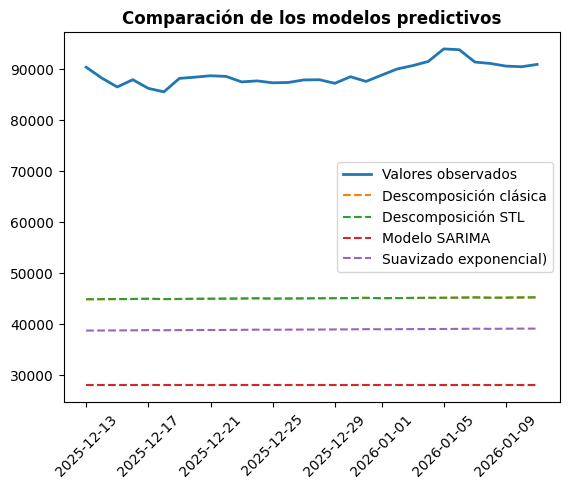

In [196]:
#Comparción gráfica
plt.plot(test.iloc[-30:],label='Valores observados', linewidth=2)
plt.plot(clasic_pred.iloc[-30:], label='Descomposición clásica', linestyle='--')
plt.plot(stl_pred.iloc[-30:], label='Descomposición STL', linestyle='--')
plt.plot(arima_auto_pred.iloc[-30:], label='Modelo SARIMA', linestyle='--')
plt.plot(suaviza_pred.iloc[-30:], label='Suavizado exponencial)', linestyle='--')
plt.legend()
plt.xticks(rotation=45)
plt.title('Comparación de los modelos predictivos',fontweight='bold')
plt.show()

In [200]:
#Capturamos MAPE Y RSME
metricas=[]
for pred in [clasic_pred,stl_pred,arima_auto_pred,suaviza_pred]:
    valor_mape=round(mape(test, pred)*100, 4)
    valor_rmse=round(np.sqrt(mse(test, pred)), 4)
    metricas.append([valor_mape, valor_rmse])
print(pd.DataFrame(metricas, index=['Decomposición clásica', 'Descomposición STL', 'SARIMA', 'Suavizado Exponencial'], 
                                    columns=['MAPE (%)', 'RSME ($/BTC)']).sort_values(by='MAPE (%)'))

                       MAPE (%)  RSME ($/BTC)
Decomposición clásica   44.8247    45249.5366
Descomposición STL      44.8247    45249.5366
Suavizado Exponencial   53.3420    50856.3014
SARIMA                  59.7329    57052.2387
